In [44]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def merge_nonbuilder_latencies(latency_files, node_type):
    """
    Merge all validator latency files into one dataframe
    """
    
    latency_dfs = []
    for latency_file in latency_files:
        latency_df = pd.read_csv(latency_file)
        latency_df['filename'] = latency_file.replace("_latency_stats_" +node_type+ ".csv", "")
        latency_df["node_type"] = node_type
        latency_df['block_id'] = range(len(latency_df))
        latency_df = latency_df[ ["node_type", "filename", "block_id", "Total Sampling Latency (us)"] ]
        
        latency_dfs.append(latency_df)

    return pd.concat(latency_dfs)

def get_nonbuilder_df(latency_files, node_type):
    latency_df = merge_nonbuilder_latencies(latency_files, node_type)
    latency_df['Latency (s)'] = latency_df['Total Sampling Latency (us)'] / 1_000_000
    latency_df = latency_df[ ["node_type", "filename", "block_id", "Latency (s)"] ]

    return latency_df

def get_latency_files(node_type):
    if node_type == "builder":
        return [file for file in os.listdir() if file.endswith('builder.csv') and "latency_stats" in file.lower()][0]
    else:
        return [file for file in os.listdir() if file.endswith('_' +node_type+ '.csv') and "latency_stats" in file.lower()]

def get_total_putgets(node_id, node_type):
    total_stats_files = [file for file in os.listdir() if node_id in file and 'total_stats' in file.lower()]
    
    total_stats_file = total_stats_files[0]

    total_stats_df = pd.read_csv(total_stats_file)

    if node_type == "builder":
        total_putgets = total_stats_df['Total PUT messages'][0]
        failed_putgets = total_stats_df['Total failed PUTs'][0]
    else:
        total_putgets = total_stats_df['Total GET messages'][0]
        failed_putgets = total_stats_df['Total failed GETs'][0]

    return total_putgets, failed_putgets

def get_total_stats(latency_df):
    for index, row in latency_df.iterrows():
        total_putgets, failed_putgets = get_total_putgets(row['filename'], row['node_type'])
        success_putgets = total_putgets - failed_putgets
        latency_df.loc[index, 'Total PUT/GETs'] = total_putgets
        latency_df.loc[index, 'Successful PUT/GETs'] = success_putgets

    return latency_df

def get_operations():
    # Get the operation files for each node
    operation_files = [file for file in os.listdir() if file.endswith(".csv") and "operations" in file.lower() and "putget_operations.csv" not in file.lower()]
    
    operations_df = pd.DataFrame()

    for operation_file in operation_files:
        operation_df = pd.read_csv(operation_file)
        
        nan_count = operation_df['Block ID'].isna().sum()
        if nan_count > 0:
            before = len(operation_df)
            # Remove any rows with NaN values in the Block ID column
            operation_df = operation_df.dropna(subset=['Block ID'])
            after = len(operation_df)
            print("Removed " + str(before - after) + " rows with NaN values from " + operation_file)

        operation_df['node_id'] = operation_file.split("_")[0]
        operation_df['node_type'] = operation_file.split("_")[2].replace(".csv", "")
        operation_df['timestamps'] = pd.to_datetime(operation_df['PUT timestamps'].fillna(operation_df['GET timestamps']), format='%H:%M:%S.%f')
        operation_df['latencies_us'] = operation_df['PUT latencies'].fillna(operation_df['GET latencies'])
        operation_df['Block ID'] = operation_df['Block ID'].astype(int)
        operation_df['Block ID'] = operation_df['Block ID'] + 1
        operation_df["block_parcel_id"] = (operation_df['Block ID'] * 1_000_000_000) + operation_df['Parcel ID']

        operations_df = pd.concat([operations_df, operation_df])

    # Find the minimum timestamp for each node_type
    min_timestamps = operations_df.groupby('node_type')['timestamps'].min()

    # Calculate the time offset for each node_type to synchronize them
    offsets = min_timestamps - min_timestamps.min()

    # Apply the time offset to synchronize timestamps
    operations_df['synced_timestamps'] = operations_df['timestamps']
    operations_df['synced_timestamps'] -= operations_df['node_type'].map(offsets)

    # Convert the synchronized timestamps back to the original format
    operations_df['synced_timestamps'] = operations_df['synced_timestamps'].dt.strftime('%H:%M:%S.%f')

    # Calculate the elapsed duration in nanoseconds
    operations_df['synced_elapsed_duration_ms'] = operations_df['synced_timestamps'].apply(lambda x: pd.to_timedelta(x).total_seconds() * 1e6)
    operations_df['elapsed_duration_ms'] = operations_df['timestamps'].apply(lambda x: pd.to_timedelta(str(x).replace('-', '')).total_seconds() * 1e6)

    # Take the minimum duration from all elapsed durations to reset to 0 as the starting point
    min_duration = operations_df['synced_elapsed_duration_ms'].min()
    operations_df['synced_elapsed_duration_ms'] -= min_duration
    min_duration = operations_df['elapsed_duration_ms'].min()
    operations_df['elapsed_duration_ms'] -= min_duration

    # Delete the PUT/GET timestamps and latencies columns
    operations_df = operations_df.drop(columns=['PUT timestamps', 'PUT latencies', 'GET timestamps', 'GET latencies', 'GET hops'])

    row_count_before = len(operations_df)
    # Remove any rows with NaN values
    operations_df = operations_df.dropna()
    row_count_after = len(operations_df)
    print("Removed " + str(row_count_before - row_count_after) + " rows with NaN values from operations_df")

    return operations_df

Removed 0 rows with NaN values from operations_df


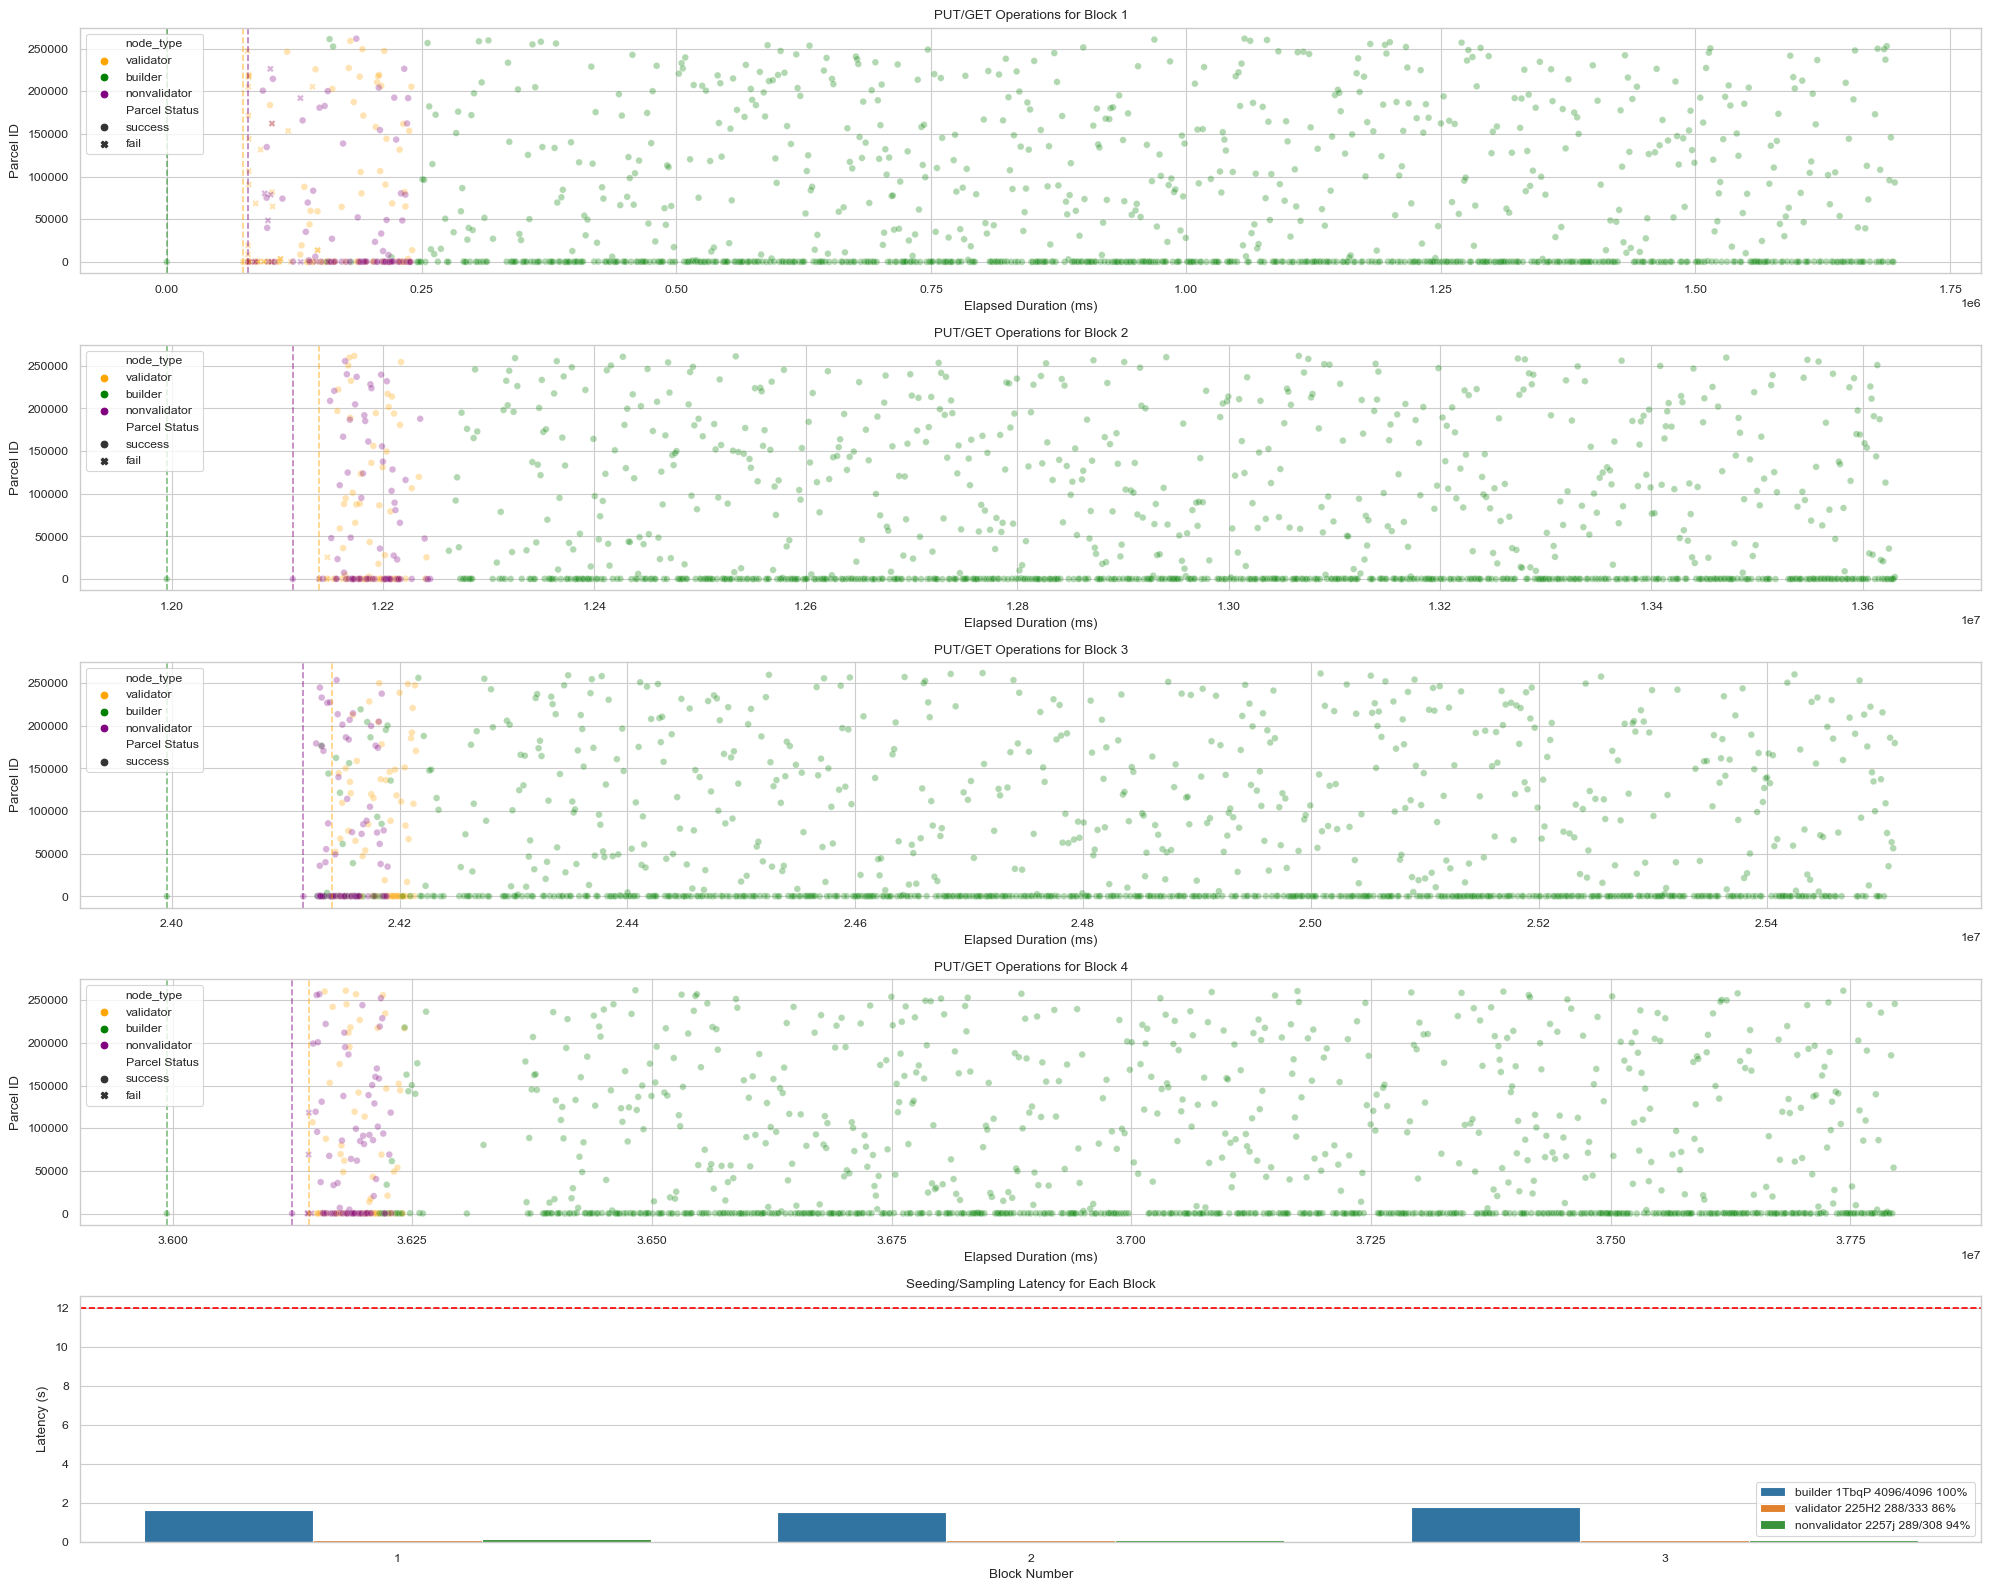

In [50]:

builder_latency_file = get_latency_files("builder")
validator_latency_files = get_latency_files("validator")
non_validator_latency_files = get_latency_files("nonvalidator")

validator_latency_df = get_nonbuilder_df(validator_latency_files, "validator")
non_validator_latency_df = get_nonbuilder_df(non_validator_latency_files, "nonvalidator")

validator_latency_df = get_total_stats(validator_latency_df)
non_validator_latency_df = get_total_stats(non_validator_latency_df)

# Get builder latency stats
builder_latency_df = pd.read_csv(builder_latency_file)
builder_latency_df['Latency (s)'] = builder_latency_df['Seeding Latency (us)'] / 1_000_000
builder_latency_df['filename'] = builder_latency_file.replace("_latency_stats_builder.csv", "")
builder_latency_df['block_id'] = range(len(builder_latency_df))
builder_latency_df["node_type"] = "builder"
builder_latency_df = builder_latency_df[ ["node_type", "filename", "block_id", "Latency (s)"] ]
builder_latency_df = get_total_stats(builder_latency_df)

# Merge all latency stats
latency_df = pd.concat([builder_latency_df, validator_latency_df, non_validator_latency_df])
latency_df['node_label'] = latency_df['node_type'] + " " + latency_df['filename'].apply(lambda x: x[:5])
latency_df['Successful PUT/GETs'] = latency_df['Successful PUT/GETs'].astype(int)
latency_df['Total PUT/GETs'] = latency_df['Total PUT/GETs'].astype(int)
latency_df['Successful/Total Label'] = latency_df['Successful PUT/GETs'].astype(str) + '/' + latency_df['Total PUT/GETs'].astype(str)
latency_df['Percentage'] = (latency_df['Successful PUT/GETs'] / latency_df['Total PUT/GETs'] * 100).round().astype(int)
latency_df['node_label'] = latency_df['node_label'] + " " + latency_df['Successful/Total Label'].astype(str) + " " + latency_df['Percentage'].astype(str) + "%"

# Remove first and last block
latency_df = latency_df[ (latency_df['block_id'] != 0) & (latency_df['block_id'] != len(builder_latency_df)) ]

putget_operations_df = get_operations()
putget_operations_df.to_csv("putget_operations.csv", index=False)

sns.set_style("whitegrid")
sns.set_context("paper")

block_ids = putget_operations_df['Block ID'].unique()
fig, axes = plt.subplots( len(block_ids) + 1 , 1, figsize=(20, 4*len(block_ids)))
putget_operations_df_grouped = putget_operations_df.groupby("Block ID")

hues = {
    "builder": "green",
    "validator": "orange",
    "nonvalidator": "purple"
}

for block_id, block_df in putget_operations_df_grouped:
    block_id_index = block_id - 1
    ax = axes[block_id_index]
    
    x_col = "elapsed_duration_ms"

    sns.scatterplot(x=x_col, y="Parcel ID", hue="node_type", data=block_df, ax=ax, alpha=0.3, palette=hues, style="Parcel Status")

    # Plot the starting signal vertical lines
    starting_signal_df = block_df[block_df['Parcel ID'] == -1]
    for index, row in starting_signal_df.iterrows():
        if row['node_type'] == "builder":
            ax.axvline(x=row[x_col], color='green', linestyle='--', alpha=0.5)
        elif row['node_type'] == "validator":
            ax.axvline(x=row[x_col], color='orange', linestyle='--', alpha=0.5)
        elif row['node_type'] == "nonvalidator":
            ax.axvline(x=row[x_col], color='purple', linestyle='--', alpha=0.5)

    ax.set_title("PUT/GET Operations for Block " + str(block_id))
    ax.set_xlabel("Elapsed Duration (ms)")
    # ax.set_xticks([])
    # ax.set_xticklabels([])
    ax.set_ylabel("Parcel ID")
    ax.legend()

i = len(block_ids)
plt.title("Seeding/Sampling Latency for Each Block")
sns.barplot(x="block_id", y="Latency (s)", hue="node_label", data=latency_df, ax=axes[i])
axes[i].set_xlabel("Block Number")
axes[i].set_ylabel("Latency (s)")
axes[i].axhline(y=12, color='red', linestyle='--')
axes[i].legend()

plt.tight_layout()
plt.show()